# CAPSTONE: Modeling and Evaluation

**Storm Intensity Change Prediction**<br><br>
**Author: Ishan Singh Bhullar**<br>
**Date: 11 December 2022**<br>
**Contact: ishanbhullar@gmail.com**<br>

## Table of Contents

1. [Introduction](#Introduction)<br><br>
2. [Modeling and Evaluation](#Modeling-and-Evaluation)<br><br>
    - [X (features) and y (target)](#X-(features)-and-y-(target))<br><br>
    - [Test, Train, Validation Split](#Test,-Train,-Validation-Split)<br><br>
    - [Statsmodels Logistic Regression](#Statsmodels-Logistic-Regression)<br><br>
    - [Logistic Regression Model](#Logistic-Regression-Model)<br><br>
    - [Random Forest](#Random-Forest)<br><br>
    - [XGBoost Model](#XGBoost-Model)<br><br>
3. [Summary](#Summary)<br><br>


## Introduction

In this notebook, I will be training various models to effectively predict the target variable. Let's start by stating/describing the target variable and variable features. 

The target variable is called `intensity_delta` and it is an engineered label based on whether current storm conditions cause an increase (1 for increase, 0 for no increase) in surface winds 6 hours in the future. This can be an effective first step in gauging whether a storm is intensifying or not. 

### Models Used

I will be training the following models in this notebook to work towards the goal of predicting the target variable:
1. Logistic Regression - I don't have high hopes for this model as the data is quite non-linear in nature. This will help set up a base model to compare others against.
2. Decision Trees - This model should fare better in theory due to its ability to map non-linear boundaries. 
3. Random Forests and XGBoost (Gradient Boosted Decision Trees) - These should be the most promising, delivering the best results. However, I will have to be careful with hyperparamter optimization to prevent overfitting which these models are quite prone to.

### Evaluation Metrics

When predicting calamitous events, it is important to not miss one in order to minimize casualties.. At the same time, false alarms can be very expensive economically. For evaluation I want to balance between minimizing False Positives and False Negatives. I will be using the following metrics to evaluate models:
- Accuracy Scores - How well the model predicts the target variable.
- Recall (True Positive Rate) - The ratio of correct positive predictions to total postive values.
$$R=\frac{TP}{TP+FN}$$
- Precision - The ratio of correct positive predictions to total positive predictions.
$$R=\frac{TP}{TP+FP}$$
- F1 Score - The harmonic mean of Recall and Precision. USeful to try and balance Precision and Recall.

### Importing Relevant Libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [245]:
from datetime import datetime
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")
import joblib

In [255]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, classification_report

from xgboost import XGBClassifier

### Custom Functions

#### Runtime Function

In [51]:
def timer(started=None):
    '''
    A simple function to print runtime of a line or block of lines of code and return the resulting
    datetime.timedelta variable.
    
    It accepts one datetime parameter which is used in an If loop to decide
    whether the timer is starting or stopping.
    
    Parameters
    ---------------
    started: datetime type
        Default value = False
        
    Returns
    ---------------
    If started parameter is None, returns current time.
    If started parameter is not None:
        1. prints runtime of code 
        2. datetime.timedelta variable.
    '''  
    if started==None:
        return datetime.now()
    else:
        end = datetime.now()
        runtime = end - started
        print(f'The runtime of your code is: {runtime} (h:mm:ss)')
        return runtime

### Reading Data

In [52]:
model_df = pd.read_csv("\data\model_data.csv", index_col=0)

In [53]:
model_df.head()

,time,lat,lon,dist2land,wind_surface,pressure_surface,category,storm_speed,storm_dir,geo_250,...,u_dir_550,v_wind_550,v_dir_550,geo_850,u_wind_850,u_dir_850,v_wind_850,v_dir_850,wind_lag,intensity_delta
0,1959-06-01 00:00:00,32.1000,-90.5000,0,25.0,1008.0,depression,6,42,106941.04,...,1,0.103929,1,14684.576,1.299480,1,2.507897,1,25.0,0.0
1,1959-06-01 03:00:00,32.2799,-90.2298,0,25.0,1008.0,depression,6,59,106903.90,...,1,1.907968,0,14733.608,0.864694,1,2.880090,1,25.0,0.0
2,1959-06-01 06:00:00,32.4000,-89.9000,0,25.0,1008.0,depression,6,69,106783.48,...,1,2.847706,0,14732.032,2.117519,1,3.888728,1,25.0,0.0
3,1959-06-01 09:00:00,32.5150,-89.5150,0,25.0,1008.0,depression,7,74,106455.28,...,0,1.913183,0,14646.824,3.203289,1,2.605515,1,25.0,0.0
4,1959-06-01 12:00:00,32.6000,-89.1000,0,25.0,1008.0,depression,7,78,106473.04,...,1,1.893531,1,14696.572,2.416132,1,0.628975,1,25.0,0.0


In [54]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27531 entries, 0 to 28797
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              27531 non-null  object 
 1   lat               27531 non-null  float64
 2   lon               27531 non-null  float64
 3   dist2land         27531 non-null  int64  
 4   wind_surface      27531 non-null  float64
 5   pressure_surface  27531 non-null  float64
 6   category          27531 non-null  object 
 7   storm_speed       27531 non-null  int64  
 8   storm_dir         27531 non-null  int64  
 9   geo_250           27531 non-null  float64
 10  u_wind_250        27531 non-null  float64
 11  u_dir_250         27531 non-null  int64  
 12  v_wind_250        27531 non-null  float64
 13  v_dir_250         27531 non-null  int64  
 14  geo_550           27531 non-null  float64
 15  u_wind_550        27531 non-null  float64
 16  u_dir_550         27531 non-null  int64 

Everything looks fine, we just have to change the `time` column to datetime format.

In [55]:
# convert column to datetime format
model_df['time'] = pd.to_datetime(model_df['time'])
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27531 entries, 0 to 28797
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              27531 non-null  datetime64[ns]
 1   lat               27531 non-null  float64       
 2   lon               27531 non-null  float64       
 3   dist2land         27531 non-null  int64         
 4   wind_surface      27531 non-null  float64       
 5   pressure_surface  27531 non-null  float64       
 6   category          27531 non-null  object        
 7   storm_speed       27531 non-null  int64         
 8   storm_dir         27531 non-null  int64         
 9   geo_250           27531 non-null  float64       
 10  u_wind_250        27531 non-null  float64       
 11  u_dir_250         27531 non-null  int64         
 12  v_wind_250        27531 non-null  float64       
 13  v_dir_250         27531 non-null  int64         
 14  geo_550           2753

Column converted successfully. 

### Encoding Non-Numeric Columns

There is only one non-numerica data column in the dataset - `category`. It consists of three classes: 'depression, 'storm' and 'severe'. We can go with dummy encoding for this column.

In [56]:
# dummy or one hot encoding `category` column
model_df = pd.get_dummies(model_df, columns=['category'], prefix='category')

In [57]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27531 entries, 0 to 28797
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 27531 non-null  datetime64[ns]
 1   lat                  27531 non-null  float64       
 2   lon                  27531 non-null  float64       
 3   dist2land            27531 non-null  int64         
 4   wind_surface         27531 non-null  float64       
 5   pressure_surface     27531 non-null  float64       
 6   storm_speed          27531 non-null  int64         
 7   storm_dir            27531 non-null  int64         
 8   geo_250              27531 non-null  float64       
 9   u_wind_250           27531 non-null  float64       
 10  u_dir_250            27531 non-null  int64         
 11  v_wind_250           27531 non-null  float64       
 12  v_dir_250            27531 non-null  int64         
 13  geo_550              27531 non-

In [58]:
model_df.columns

Index(['time', 'lat', 'lon', 'dist2land', 'wind_surface', 'pressure_surface',
       'storm_speed', 'storm_dir', 'geo_250', 'u_wind_250', 'u_dir_250',
       'v_wind_250', 'v_dir_250', 'geo_550', 'u_wind_550', 'u_dir_550',
       'v_wind_550', 'v_dir_550', 'geo_850', 'u_wind_850', 'u_dir_850',
       'v_wind_850', 'v_dir_850', 'wind_lag', 'intensity_delta',
       'category_depression', 'category_severe', 'category_storm'],
      dtype='object')

We need to drop one of the dummy columns to avoid multi-collinearity. Let's drop the `category_severe` column.

In [59]:
# dropping column
model_df.drop(columns='category_severe', inplace=True)
model_df.columns #sanity check

Index(['time', 'lat', 'lon', 'dist2land', 'wind_surface', 'pressure_surface',
       'storm_speed', 'storm_dir', 'geo_250', 'u_wind_250', 'u_dir_250',
       'v_wind_250', 'v_dir_250', 'geo_550', 'u_wind_550', 'u_dir_550',
       'v_wind_550', 'v_dir_550', 'geo_850', 'u_wind_850', 'u_dir_850',
       'v_wind_850', 'v_dir_850', 'wind_lag', 'intensity_delta',
       'category_depression', 'category_storm'],
      dtype='object')

----------------------------

## Modeling and Evaluation

### X (features) and y (target)

Let's start by declaring the features and target label. 

In [60]:
model_df.columns

Index(['time', 'lat', 'lon', 'dist2land', 'wind_surface', 'pressure_surface',
       'storm_speed', 'storm_dir', 'geo_250', 'u_wind_250', 'u_dir_250',
       'v_wind_250', 'v_dir_250', 'geo_550', 'u_wind_550', 'u_dir_550',
       'v_wind_550', 'v_dir_550', 'geo_850', 'u_wind_850', 'u_dir_850',
       'v_wind_850', 'v_dir_850', 'wind_lag', 'intensity_delta',
       'category_depression', 'category_storm'],
      dtype='object')

I will not be including any of the 550hPa variables as they are closely correlated to 250hPa and 850hPa variables as we saw in the EDA Notebook. Further, since we are trying to predict change in intensity of surface wind, I will keep the `wind_surface` feature and drop `pressure_surface` feature (as they have an almost perfect correlation).


In [129]:
X = model_df.drop(columns=['time', 'pressure_surface', 'geo_550', 'u_wind_550', 
                           'u_dir_550', 'v_wind_550', 'v_dir_550', 'wind_lag', 'intensity_delta'])
X.columns

Index(['lat', 'lon', 'dist2land', 'wind_surface', 'storm_speed', 'storm_dir',
       'geo_250', 'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250',
       'geo_850', 'u_wind_850', 'u_dir_850', 'v_wind_850', 'v_dir_850',
       'category_depression', 'category_storm'],
      dtype='object')

In [130]:
y = model_df[['intensity_delta']]
y

,intensity_delta
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
28793,0.0
28794,0.0
28795,0.0
28796,0.0


### Test, Train, Validation Split

First, I will split the features and labels into test and remainder sets. This is done to prevent data leakage which can bias the results of our models. We will then split the remainder set further into train and validation sets. This is done so that we can keep the test set completely hidden from the model.

In [131]:
# setting the split ratio
split_ratio = 0.25 # 25% of data goes into test set

In [132]:
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, 
                                                            test_size=split_ratio, stratify=y, random_state=1)

In [133]:
# sanity check
X.shape[0] == X_remainder.shape[0] + X_test.shape[0]

True

In [134]:
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, 
                                                                test_size=split_ratio, stratify=y_remainder, random_state=1)

In [135]:
# sanity check
X_remainder.shape[0] == X_train.shape[0] + X_validation.shape[0]

True

I will start with a statsmodels Logistic Regression model. This, in addition to the correlation matrix from the EDA Notebook, will allow me to get a closer look at the variables and decide which ones to feature in more advanced models. Since, we are not interested in accuracy scores, I will forego the scaling for this step. Let's use the remainder data set for this.

### Statsmodels Logistic Regression

#### Iteration 1

In [136]:
# We need to manually add an intercept for statsmodels logit
X_train_wc = sm.add_constant(X_train)
X_train_wc.head()

,const,lat,lon,dist2land,wind_surface,storm_speed,storm_dir,geo_250,u_wind_250,u_dir_250,v_wind_250,v_dir_250,geo_850,u_wind_850,u_dir_850,v_wind_850,v_dir_850,category_depression,category_storm
2577,1.0,20.000,-58.8000,736,25.0,10,42,106635.88,16.072563,1,8.375745,0,14826.376,0.543960,0,1.580342,1,1,0
22770,1.0,35.269,-38.2722,1765,72.0,24,358,105226.94,1.256100,0,18.352348,1,14019.216,1.029442,1,11.933826,1,0,1
25076,1.0,13.300,-50.6000,918,35.0,13,282,107423.66,7.818411,0,0.428727,0,14747.231,1.195222,1,5.580057,1,0,1
13092,1.0,35.200,-42.8000,1535,85.0,18,83,105825.46,15.006169,1,1.166901,0,13498.480,5.785726,1,3.113857,0,0,1
9261,1.0,25.300,-96.8000,51,50.0,9,31,107191.97,3.097380,1,0.955518,0,14183.869,1.004887,1,3.435564,1,0,1


In [137]:
# 1. Instantiate model
mylogreg_one = sm.Logit(y_train, X_train_wc)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_one = mylogreg_one.fit()
mylogreg_results_one.summary()

Optimization terminated successfully.
         Current function value: 0.584233
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                15486
Model:                          Logit   Df Residuals:                    15467
Method:                           MLE   Df Model:                           18
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                 0.05587
Time:                        22:09:10   Log-Likelihood:                -9047.4
converged:                       True   LL-Null:                       -9582.9
Covariance Type:            nonrobust   LLR p-value:                4.978e-216
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  21.3124      3.189      6.683      0.000      15.062      27.563
lat                    -0.0455      0.003    -13.845      0.000      -0.052      -0.039
lon                    -0.0119      0.002     -7.777      0.000      -0.015      -0.009
dist2land            7.833e-05   4.59e-05      1.706      0.088   -1.17e-05       0.000
wind_surface           -0.0039      0.001     -2.790      0.005      -0.007      -0.001
storm_speed             0.0239      0.004      5.931      0.000       0.016       0.032
storm_dir              -0.0008      0.000     -3.870      0.000      -0.001      -0.000
geo_250                -0.0002   3.24e-05     -7.428      0.000      -0.000      -0.000
u_wind_250             -0.0147      0.004     -3.401      0.001      -0.023      -0.006
u_dir_250              -0.3125      0.044     -7.131      0.000      -0.398      -0.227
v_wind_250             -0.0406      0.005     -8.495      0.000      -0.050      -0.031
v_dir_250               0.1720      0.042      4.087      0.000       0.090       0.254
geo_850                 0.0003   5.23e-05      6.293      0.000       0.000       0.000
u_wind_850             -0.0385      0.007     -5.490      0.000      -0.052      -0.025
u_dir_850               0.1287      0.049      2.604      0.009       0.032       0.226
v_wind_850             -0.0178      0.008     -2.317      0.021      -0.033      -0.003
v_dir_850               0.0885      0.045      1.988      0.047       0.001       0.176
category_depression    -1.1009      0.141     -7.811      0.000      -1.377      -0.825
category_storm          0.0551      0.111      0.497      0.619      -0.162       0.272
=======================================================================================
"""

The p-value for `category_storm` variable is much greater than the significance level of 0.05 at 0.619. Let's drop this feature and re-run the model.

#### Iteration 2

In [138]:
# dropping column category_storm
X_train_two = X_train.drop(columns='category_storm')
X_train_two.columns

Index(['lat', 'lon', 'dist2land', 'wind_surface', 'storm_speed', 'storm_dir',
       'geo_250', 'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250',
       'geo_850', 'u_wind_850', 'u_dir_850', 'v_wind_850', 'v_dir_850',
       'category_depression'],
      dtype='object')

In [139]:
# We need to manually add an intercept for statsmodels logit
X_train_wc_two = sm.add_constant(X_train_two)
X_train_wc_two.head()

,const,lat,lon,dist2land,wind_surface,storm_speed,storm_dir,geo_250,u_wind_250,u_dir_250,v_wind_250,v_dir_250,geo_850,u_wind_850,u_dir_850,v_wind_850,v_dir_850,category_depression
2577,1.0,20.000,-58.8000,736,25.0,10,42,106635.88,16.072563,1,8.375745,0,14826.376,0.543960,0,1.580342,1,1
22770,1.0,35.269,-38.2722,1765,72.0,24,358,105226.94,1.256100,0,18.352348,1,14019.216,1.029442,1,11.933826,1,0
25076,1.0,13.300,-50.6000,918,35.0,13,282,107423.66,7.818411,0,0.428727,0,14747.231,1.195222,1,5.580057,1,0
13092,1.0,35.200,-42.8000,1535,85.0,18,83,105825.46,15.006169,1,1.166901,0,13498.480,5.785726,1,3.113857,0,0
9261,1.0,25.300,-96.8000,51,50.0,9,31,107191.97,3.097380,1,0.955518,0,14183.869,1.004887,1,3.435564,1,0


In [140]:
# 1. Instantiate model
mylogreg_two = sm.Logit(y_train, X_train_wc_two)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_two = mylogreg_two.fit()
mylogreg_results_two.summary()

Optimization terminated successfully.
         Current function value: 0.584241
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                15486
Model:                          Logit   Df Residuals:                    15468
Method:                           MLE   Df Model:                           17
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                 0.05586
Time:                        22:09:11   Log-Likelihood:                -9047.6
converged:                       True   LL-Null:                       -9582.9
Covariance Type:            nonrobust   LLR p-value:                6.976e-217
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  21.4114      3.183      6.727      0.000      15.173      27.650
lat                    -0.0453      0.003    -13.846      0.000      -0.052      -0.039
lon                    -0.0119      0.002     -7.773      0.000      -0.015      -0.009
dist2land            7.977e-05   4.58e-05      1.741      0.082   -1.01e-05       0.000
wind_surface           -0.0044      0.001     -4.133      0.000      -0.006      -0.002
storm_speed             0.0239      0.004      5.931      0.000       0.016       0.032
storm_dir              -0.0008      0.000     -3.894      0.000      -0.001      -0.000
geo_250                -0.0002   3.24e-05     -7.433      0.000      -0.000      -0.000
u_wind_250             -0.0147      0.004     -3.412      0.001      -0.023      -0.006
u_dir_250              -0.3122      0.044     -7.125      0.000      -0.398      -0.226
v_wind_250             -0.0407      0.005     -8.520      0.000      -0.050      -0.031
v_dir_250               0.1721      0.042      4.090      0.000       0.090       0.255
geo_850                 0.0003   5.23e-05      6.284      0.000       0.000       0.000
u_wind_850             -0.0384      0.007     -5.480      0.000      -0.052      -0.025
u_dir_850               0.1289      0.049      2.607      0.009       0.032       0.226
v_wind_850             -0.0177      0.008     -2.309      0.021      -0.033      -0.003
v_dir_850               0.0881      0.045      1.979      0.048       0.001       0.175
category_depression    -1.1660      0.052    -22.473      0.000      -1.268      -1.064
=======================================================================================
"""

The p-value for `dist2land` variable is greater than the significance level of 0.05 at 0.082. Let's drop this feature and re-run the model.

#### Iteration 3

In [141]:
# dropping column dist2land
X_train_three = X_train_two.drop(columns='dist2land')
X_train_three.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250', 'geo_850',
       'u_wind_850', 'u_dir_850', 'v_wind_850', 'v_dir_850',
       'category_depression'],
      dtype='object')

In [142]:
# We need to manually add an intercept for statsmodels logit
X_train_wc_three = sm.add_constant(X_train_three)
X_train_wc_three.head()

,const,lat,lon,wind_surface,storm_speed,storm_dir,geo_250,u_wind_250,u_dir_250,v_wind_250,v_dir_250,geo_850,u_wind_850,u_dir_850,v_wind_850,v_dir_850,category_depression
2577,1.0,20.000,-58.8000,25.0,10,42,106635.88,16.072563,1,8.375745,0,14826.376,0.543960,0,1.580342,1,1
22770,1.0,35.269,-38.2722,72.0,24,358,105226.94,1.256100,0,18.352348,1,14019.216,1.029442,1,11.933826,1,0
25076,1.0,13.300,-50.6000,35.0,13,282,107423.66,7.818411,0,0.428727,0,14747.231,1.195222,1,5.580057,1,0
13092,1.0,35.200,-42.8000,85.0,18,83,105825.46,15.006169,1,1.166901,0,13498.480,5.785726,1,3.113857,0,0
9261,1.0,25.300,-96.8000,50.0,9,31,107191.97,3.097380,1,0.955518,0,14183.869,1.004887,1,3.435564,1,0


In [143]:
# 1. Instantiate model
mylogreg_three = sm.Logit(y_train, X_train_wc_three)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_three = mylogreg_three.fit()
mylogreg_results_three.summary()

Optimization terminated successfully.
         Current function value: 0.584339
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                15486
Model:                          Logit   Df Residuals:                    15469
Method:                           MLE   Df Model:                           16
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                 0.05570
Time:                        22:09:12   Log-Likelihood:                -9049.1
converged:                       True   LL-Null:                       -9582.9
Covariance Type:            nonrobust   LLR p-value:                3.754e-217
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  21.8822      3.171      6.901      0.000      15.667      28.097
lat                    -0.0449      0.003    -13.760      0.000      -0.051      -0.038
lon                    -0.0100      0.001     -9.283      0.000      -0.012      -0.008
wind_surface           -0.0042      0.001     -4.017      0.000      -0.006      -0.002
storm_speed             0.0235      0.004      5.851      0.000       0.016       0.031
storm_dir              -0.0008      0.000     -3.852      0.000      -0.001      -0.000
geo_250                -0.0002   3.22e-05     -7.617      0.000      -0.000      -0.000
u_wind_250             -0.0150      0.004     -3.484      0.000      -0.023      -0.007
u_dir_250              -0.3079      0.044     -7.036      0.000      -0.394      -0.222
v_wind_250             -0.0403      0.005     -8.440      0.000      -0.050      -0.031
v_dir_250               0.1709      0.042      4.062      0.000       0.088       0.253
geo_850                 0.0003   5.15e-05      6.667      0.000       0.000       0.000
u_wind_850             -0.0379      0.007     -5.414      0.000      -0.052      -0.024
u_dir_850               0.1285      0.049      2.600      0.009       0.032       0.225
v_wind_850             -0.0178      0.008     -2.316      0.021      -0.033      -0.003
v_dir_850               0.0867      0.045      1.948      0.051      -0.001       0.174
category_depression    -1.1705      0.052    -22.582      0.000      -1.272      -1.069
=======================================================================================
"""

The p-value for `v_dir_850` variable is greater than the significance level of 0.05 at 0.051. Let's drop this feature and re-run the model.

#### Iteration 4

In [144]:
# dropping column v_dir_850
X_train_four = X_train_three.drop(columns='v_dir_850')
X_train_four.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250', 'geo_850',
       'u_wind_850', 'u_dir_850', 'v_wind_850', 'category_depression'],
      dtype='object')

In [145]:
# We need to manually add an intercept for statsmodels logit
X_train_wc_four = sm.add_constant(X_train_four)
X_train_wc_four.head()

,const,lat,lon,wind_surface,storm_speed,storm_dir,geo_250,u_wind_250,u_dir_250,v_wind_250,v_dir_250,geo_850,u_wind_850,u_dir_850,v_wind_850,category_depression
2577,1.0,20.000,-58.8000,25.0,10,42,106635.88,16.072563,1,8.375745,0,14826.376,0.543960,0,1.580342,1
22770,1.0,35.269,-38.2722,72.0,24,358,105226.94,1.256100,0,18.352348,1,14019.216,1.029442,1,11.933826,0
25076,1.0,13.300,-50.6000,35.0,13,282,107423.66,7.818411,0,0.428727,0,14747.231,1.195222,1,5.580057,0
13092,1.0,35.200,-42.8000,85.0,18,83,105825.46,15.006169,1,1.166901,0,13498.480,5.785726,1,3.113857,0
9261,1.0,25.300,-96.8000,50.0,9,31,107191.97,3.097380,1,0.955518,0,14183.869,1.004887,1,3.435564,0


In [146]:
# 1. Instantiate model
mylogreg_four = sm.Logit(y_train, X_train_wc_four)

#2. Fit the model (this returns a separate object with the parameters)
mylogreg_results_four = mylogreg_four.fit()
mylogreg_results_four.summary()

Optimization terminated successfully.
         Current function value: 0.584462
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        intensity_delta   No. Observations:                15486
Model:                          Logit   Df Residuals:                    15470
Method:                           MLE   Df Model:                           15
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                 0.05550
Time:                        22:09:13   Log-Likelihood:                -9051.0
converged:                       True   LL-Null:                       -9582.9
Covariance Type:            nonrobust   LLR p-value:                2.869e-217
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  21.3110      3.158      6.749      0.000      15.122      27.500
lat                    -0.0445      0.003    -13.677      0.000      -0.051      -0.038
lon                    -0.0101      0.001     -9.322      0.000      -0.012      -0.008
wind_surface           -0.0042      0.001     -3.944      0.000      -0.006      -0.002
storm_speed             0.0239      0.004      5.964      0.000       0.016       0.032
storm_dir              -0.0008      0.000     -3.877      0.000      -0.001      -0.000
geo_250                -0.0002   3.22e-05     -7.497      0.000      -0.000      -0.000
u_wind_250             -0.0157      0.004     -3.648      0.000      -0.024      -0.007
u_dir_250              -0.3030      0.044     -6.937      0.000      -0.389      -0.217
v_wind_250             -0.0403      0.005     -8.452      0.000      -0.050      -0.031
v_dir_250               0.1789      0.042      4.272      0.000       0.097       0.261
geo_850                 0.0004   5.14e-05      6.850      0.000       0.000       0.000
u_wind_850             -0.0380      0.007     -5.439      0.000      -0.052      -0.024
u_dir_850               0.1298      0.049      2.625      0.009       0.033       0.227
v_wind_850             -0.0148      0.008     -1.968      0.049      -0.029   -5.83e-05
category_depression    -1.1736      0.052    -22.651      0.000      -1.275      -1.072
=======================================================================================
"""

All features have p-values within the significance threshold of 0.05. So, we can keep all the variables in here for our more advanced modelling. 

In [147]:
# get list of columns to keep in final datasets
X_train_wc_four.columns

Index(['const', 'lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir',
       'geo_250', 'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250',
       'geo_850', 'u_wind_850', 'u_dir_850', 'v_wind_850',
       'category_depression'],
      dtype='object')

Let's keep decalre X and y with the new set of columns.

In [150]:
# new df with only significant featurs and target 
final_df = model_df[['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir',
       'geo_250', 'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250',
       'geo_850', 'u_wind_850', 'u_dir_850', 'v_wind_850',
       'category_depression', 'intensity_delta']]
final_df.columns

Index(['lat', 'lon', 'wind_surface', 'storm_speed', 'storm_dir', 'geo_250',
       'u_wind_250', 'u_dir_250', 'v_wind_250', 'v_dir_250', 'geo_850',
       'u_wind_850', 'u_dir_850', 'v_wind_850', 'category_depression',
       'intensity_delta'],
      dtype='object')

In [152]:
# X(features) decalaration
X = final_df.drop(columns='intensity_delta')
X.head()

,lat,lon,wind_surface,storm_speed,storm_dir,geo_250,u_wind_250,u_dir_250,v_wind_250,v_dir_250,geo_850,u_wind_850,u_dir_850,v_wind_850,category_depression
0,32.1000,-90.5000,25.0,6,42,106941.04,9.345726,1,1.314173,1,14684.576,1.299480,1,2.507897,1
1,32.2799,-90.2298,25.0,6,59,106903.90,9.797820,1,3.676654,1,14733.608,0.864694,1,2.880090,1
2,32.4000,-89.9000,25.0,6,69,106783.48,10.698173,1,7.318680,1,14732.032,2.117519,1,3.888728,1
3,32.5150,-89.5150,25.0,7,74,106455.28,14.590856,1,11.222942,1,14646.824,3.203289,1,2.605515,1
4,32.6000,-89.1000,25.0,7,78,106473.04,14.877510,1,10.828848,1,14696.572,2.416132,1,0.628975,1


In [157]:
# y (labels/target) decalration
y = final_df[['intensity_delta']]
y.sample(10)

,intensity_delta
9788,0.0
26545,0.0
21125,0.0
16953,0.0
11152,0.0
7184,0.0
6244,1.0
11797,0.0
8806,0.0
5740,0.0


### Final Test, Train, Validation Split

In [158]:
# setting the split ratio
split_ratio = 0.25 # 25% of data goes into test set

In [159]:
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, 
                                                            test_size=split_ratio, stratify=y, random_state=1)

In [160]:
# sanity check
X.shape[0] == X_remainder.shape[0] + X_test.shape[0]

True

In [161]:
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, 
                                                                test_size=split_ratio, stratify=y_remainder, random_state=1)

In [162]:
# sanity check
X_remainder.shape[0] == X_train.shape[0] + X_validation.shape[0]

True

### Scaling the Data

Let's scale the data. We will use the `MinMaxScaler` for this task as the MinMaxScaler preserves the distribution of the data. The scaler will be fit to the training data and using that to transform the training and validation data.

In [166]:
time = timer() # start timer
# Instatiate Scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(X_train)

# Transform the data
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
runtime = timer(time) # stop timer

The runtime of your code is: 0:00:00.002100 (h:mm:ss)


Now, I will fit the scaler to the entirity of the remainder data set and use it to transform the remainder and test data sets.

In [167]:
time = timer() # start timer
# Instatiate Scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(X_remainder)

# Transform the data
X_remainder_scaled = scaler.transform(X_remainder)
X_test_scaled = scaler.transform(X_test)
runtime = timer(time) # stop timer

The runtime of your code is: 0:00:00.007115 (h:mm:ss)


### Dimension Reduction

Let's conduct some dimension reduction via Principal Component Analysis (PCA).

Initially, we will instatiate and fit a PCA object to the remainder set with no value for n_components. The we will use the explained_variance_ratio_ to find the optimal number of components.

PCA object instatiation and fitting with no value for `n_components`.

In [170]:
time = timer() # start timer
# instantiate the PCA object
model_PCA = PCA()

# fitting PCA
model_PCA.fit(X_remainder_scaled)

# transforming datasets
X_remainder_scaled_PCA = model_PCA.transform(X_remainder_scaled)
X_test_scaled_PCA = model_PCA.transform(X_test_scaled)
timer(time) # stop timer

The runtime of your code is: 0:00:00.016741 (h:mm:ss)


datetime.timedelta(microseconds=16741)

We can now use the `explained_variance_ratio_` to find the best value for n_components by plotting the ratios vs the number of Principal components.

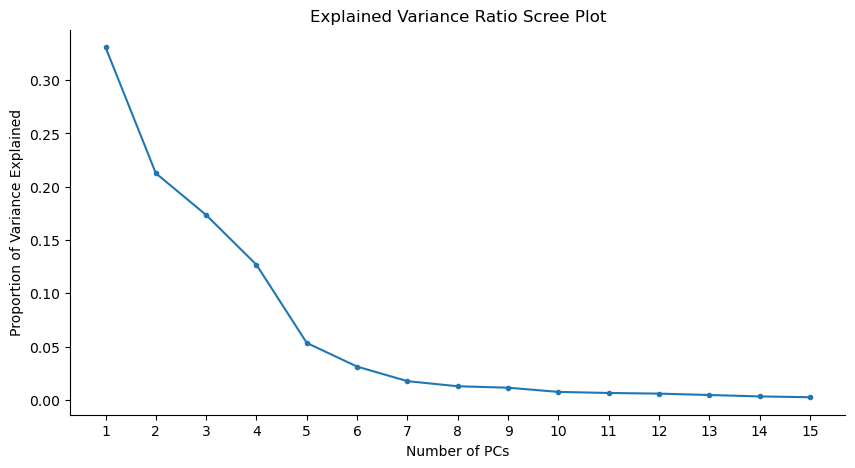

In [176]:
expl_var = model_PCA.explained_variance_ratio_

plt.figure(figsize=(10,5))

plt.plot(range(1,X_remainder_scaled.shape[1]+1),expl_var,marker='.')
plt.title('Explained Variance Ratio Scree Plot')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,X_remainder_scaled.shape[1]+1,1))


sns.despine()
plt.show()

The scree plot tells us that the ideal `n_components` for PCA would be 5 (elbow point). Let's use cumulative sums to see how many components we need to cover 80%, 90%, and 95% of variance. We will store the number of components in a list which we can later use to reduce dimension using PCA in a 5-fold GridSearchCV

In [178]:
cumulative_sum = np.cumsum(expl_var)
components = [ 
    np.argmax(cumulative_sum > 0.85) + 1,
    np.argmax(cumulative_sum > 0.9) + 1,
    np.argmax(cumulative_sum > 0.95) + 1
]
components

[5, 6, 8]

- 5 components explain 85% of varaince in data
- 6 components explain 90% of varaince in data
- 8 components explain 95% of varaince in data

### Logistic Regression Model

#### Five-fold Cross-Validation

We will use GridSearchCV and Pipeline to perform a 5-fold cross validation to optimize the following hyperparameters for Logistic Regression:

1. C or regularization 
2. solver

In addition, we will also test for 3 different values for PCA dimension reduction n_components and two different Scalers (MinMax and Standard).

First let's create the list of pipeline estimators and create the Pipeline using this list.

In [179]:
# estimators for pipeline
estimators = [
    ('scale', StandardScaler()),
    ('reduce_dim', PCA()),
    ('LR', LogisticRegression())
]

# pipeline creation
pipe = Pipeline(estimators)

Next, let's create the `param-grid`:

In [183]:
# param-grid
params = [
    {'LR': [LogisticRegression(max_iter=5000, penalty='l2', random_state=1)],
     'scale': [StandardScaler(), MinMaxScaler()],
     'reduce_dim': [PCA()],
     'LR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'LR__solver': ['liblinear', 'lbfgs'],
     'reduce_dim__n_components': [6, 8, None]
    }
]

Now we create `GridSearchCV` object and fit the grid to the remainder data.

In [184]:
time = timer() # start timer
# GridSearchCv object
grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

# fitting the grid
fittedgrid = grid.fit(X_remainder, y_remainder)
runtime = timer(time)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV

[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.001, LR__solver=lbfgs,

[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.01, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.01, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.01, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.01, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.01, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.01, LR__solver=lbfgs, red

[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=None, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=None, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=None, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=None, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=0.1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=None, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1),

[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1, LR__solver=libl

[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=None, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=None, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=None, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=10, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=10, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=10, LR__solver=liblinea

[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=10, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=10, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=10, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=10, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=10, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=10, LR__solver=lbfgs, reduce_dim=PCA(), r

[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=100, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=100, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=100, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=100, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=100, LR__solver=lbfgs, reduce_dim=PCA(), reduce_dim__n_components=6, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=100, LR__solver=lbfgs, reduc

[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1000, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=8, scale=MinMaxScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1000, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=None, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1000, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=None, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1000, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=None, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1), LR__C=1000, LR__solver=liblinear, reduce_dim=PCA(), reduce_dim__n_components=None, scale=StandardScaler(); total time=   0.0s
[CV] END LR=LogisticRegression(max_iter=5000, random_state=1

Let's find the best params and model.

In [185]:
# best model
best_model = fittedgrid.best_estimator_

In [186]:
# Best set of parameters
fittedgrid.best_params_

{'LR': LogisticRegression(C=1000, max_iter=5000, random_state=1, solver='liblinear'),
 'LR__C': 1000,
 'LR__solver': 'liblinear',
 'reduce_dim': PCA(),
 'reduce_dim__n_components': None,
 'scale': MinMaxScaler()}

In [187]:
# best score
fittedgrid.best_score_

0.6958058075022415

#### Evaluation

##### Accuracy Scores

Let's fit the best model to the reaminder set and calculate accuracy scores.

In [188]:
time = timer()
# fit best_model
best_model.fit(X_remainder, y_remainder)
runtime = timer(time)

The runtime of your code is: 0:00:00.102023 (h:mm:ss)


In [189]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {best_model.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {best_model.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.696241766757071
Test Set Score: 0.691413627778585
The runtime of your code is: 0:00:00.006114 (h:mm:ss)


In [191]:
final_df['intensity_delta'].value_counts(normalize=True)

0.0    0.690313
1.0    0.309687
Name: intensity_delta, dtype: float64

##### Precision and Recall

Let's plot the confusion matrix for the Logistic Regression model and get prediction for test set.

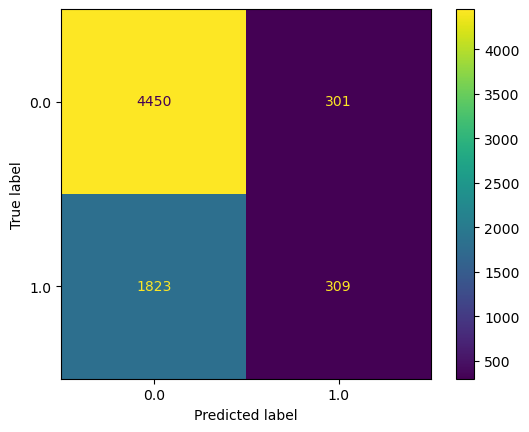

In [195]:
# plotting confusion matrix
plot_confusion_matrix(best_model, X_test, y_test);

In [198]:
# Get class predictions
y_pred = best_model.predict(X_test)

Let's get the Classification report.

In [202]:
# Classification score
logit_report = classification_report(y_test, y_pred)
print(logit_report)

              precision    recall  f1-score   support

         0.0       0.71      0.94      0.81      4751
         1.0       0.51      0.14      0.23      2132

    accuracy                           0.69      6883
   macro avg       0.61      0.54      0.52      6883
weighted avg       0.65      0.69      0.63      6883



Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                          |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|------------------------------------------------------------------------------|
| Logistic Regression | 0.696                  | 0.691             | 0.14       | 0.51          | 0.23         | MinMaxScaler(), No dimension reduction,  LR__C=1000, LR__solver='liblinear'  |

Recall of 0.14 and Precision of 0.51 are quite bad. Let's see if we can increase them with other models.

### Decision Tree Model

#### Optimize for `max_depth`

Let's use a for loop to optimize for max_depth. We will also use the unscaled train and validation sets for this.

In [206]:
# running model for different max depths
depths = list(range(1, int(np.sqrt(len(X_train))))) # range of max_depths to be tested
train_scores_dt = []
validation_scores_dt = []

for d in tqdm(depths):

    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train, y_train)
        
    # Evaluate
    train_scores_dt.append(dt.score(X_train, y_train))
    validation_scores_dt.append(dt.score(X_validation, y_validation))



100%|██████████| 123/123 [00:22<00:00,  5.54it/s]


Let's plot the accuracy scores against max_depth to find out the best max_depth value.

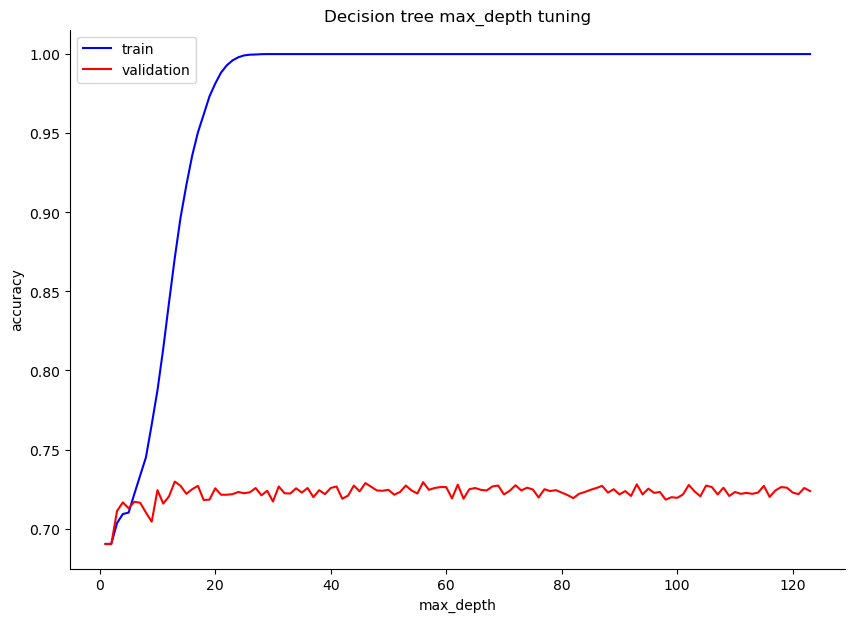

The runtime of your code is: 0:00:00.111494 (h:mm:ss)


In [207]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depths, train_scores_dt, c='blue', label='train')
plt.plot(depths, validation_scores_dt, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Decision tree max_depth tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

From the plot, we can see that the model starts to seriously over fit sometime around a max_depth of 10. Let's make a plot for max_depth from 1-20.

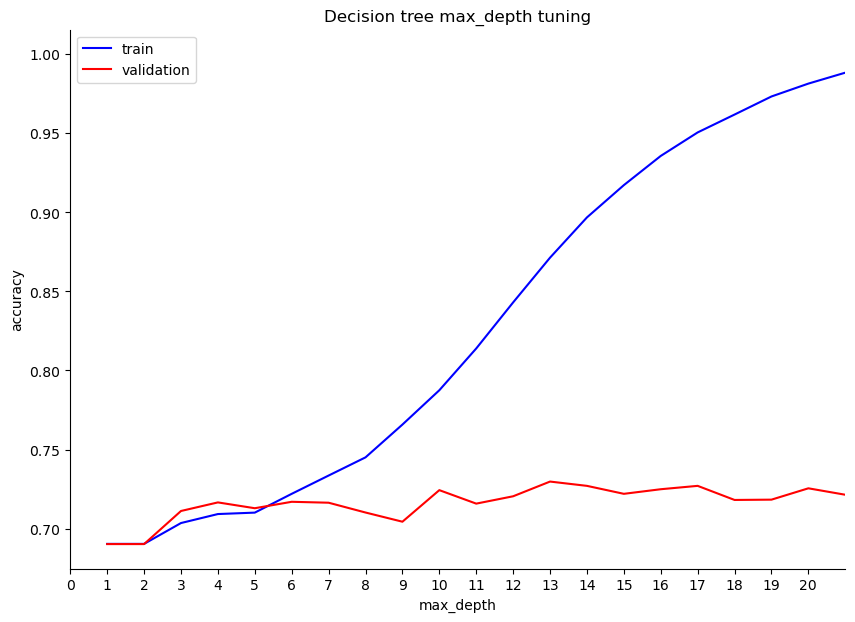

The runtime of your code is: 0:00:00.134025 (h:mm:ss)


In [208]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depths, train_scores_dt, c='blue', label='train')
plt.plot(depths, validation_scores_dt, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Decision tree max_depth tuning")
plt.xlim([1,21])
plt.xticks(range(0,21,1))
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Based on the plot, we will choose a max_depth of 6. This will maximize test set accuracy while keeping over-fitting low. max_depth of 5 would also be a good option.

Let's find the accuracy score for a DT Classifier model with max_depth of 6.

In [209]:
time = timer() # start timer

# Instantiate DT model
dt = DecisionTreeClassifier(max_depth=6, random_state=1)

# Fit the model
dt.fit(X_train, y_train)

runtime = timer(time) # stop timer

The runtime of your code is: 0:00:00.088698 (h:mm:ss)


In [211]:
time = timer()
# Accuracy scores
print(f'Train Set Score: {dt.score(X_train, y_train)}')
print(f'Validation Set Score: {dt.score(X_validation, y_validation)}')
runtime = timer(time)

Train Set Score: 0.7220069740410694
Validation Set Score: 0.7171638899651298
The runtime of your code is: 0:00:00.008008 (h:mm:ss)


We can see that the Decision Tree model is performing slightly better than the Logistic Regression model. Let's evaluate the model on the test data.

#### Evaluation

##### Accuracy Scores

Let's fit the best model to the reaminder set and calculate accuracy scores.

In [212]:
# training model on remainder data
time = timer() # start timer

# Instantiate DT model
dt = DecisionTreeClassifier(max_depth=6, random_state=1)

# Fit the model
dt.fit(X_remainder, y_remainder)

runtime = timer(time) # stop timer

The runtime of your code is: 0:00:00.112416 (h:mm:ss)


In [213]:
time = timer()
# Accuracy scores
print(f'Remainder Set Score: {dt.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {dt.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.7221522665633475
Test Set Score: 0.7175650152549761
The runtime of your code is: 0:00:00.009015 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Decision Tree model and get prediction for test set.

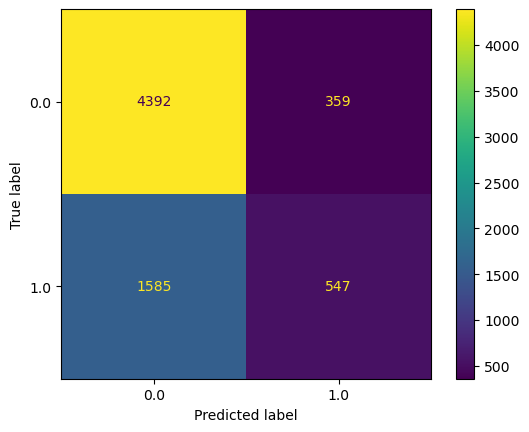

In [214]:
# plotting confusion matrix
plot_confusion_matrix(dt, X_test, y_test);

In [215]:
# Get class predictions
y_pred = dt.predict(X_test)

Let's get the Classification report.

In [216]:
# Classification score
dt_report = classification_report(y_test, y_pred)
print(dt_report)

              precision    recall  f1-score   support

         0.0       0.73      0.92      0.82      4751
         1.0       0.60      0.26      0.36      2132

    accuracy                           0.72      6883
   macro avg       0.67      0.59      0.59      6883
weighted avg       0.69      0.72      0.68      6883



Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                          |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|------------------------------------------------------------------------------|
| Logistic Regression | 0.696                  | 0.691             | 0.14       | 0.51          | 0.23         | MinMaxScaler(), No dimension reduction,  LR__C=1000, LR__solver='liblinear'  |
|  Decision Tree 1    | 0.722                  | 0.717             | 0.26       | 0.60          | 0.36         | max_depth=6                                                                  |

Recall has increased to 0.26 and Precision to 0.60. These values are still quite bad. Let's continue testing other models. 

Let's run a `GridSearchCV` and see if we can improve on these scores.

#### 5-fold Cross Validation

In [217]:
# estimators for pipeline
estimators = [
    ('reduce_dim', PCA()),
    ('DT', DecisionTreeClassifier())
]

# pipeline creation
pipe = Pipeline(estimators)

Next, let's create the `param-grid`:

In [218]:
# param-grid
params = [
    {'DT': [DecisionTreeClassifier(random_state=1)],
     'reduce_dim': [PCA()],
     'DT__max_depth': [5, 6, 7],
     'DT__criterion': ['gini', 'entropy'],
     'reduce_dim__n_components': [6, 8, None]
    }
]

Now we create `GridSearchCV` object and fit the grid to the remainder data.

In [219]:
time = timer() # start timer
# GridSearchCv object
grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

# fitting the grid
fittedgrid = grid.fit(X_remainder, y_remainder)
runtime = timer(time)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=gini, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   0.0s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=gini, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   0.0s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=gini, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   0.0s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=gini, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   0.0s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=gini, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   0.0s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=gini, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.0s
[CV] END DT=Dec

[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=entropy, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.0s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=entropy, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.0s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=entropy, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=entropy, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=entropy, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(random_state=1), DT__criterion=entropy, DT__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.1s
[CV] END DT=DecisionTreeClassifier(random_stat

Let's find the best params and model.

In [220]:
# best model
best_model = fittedgrid.best_estimator_

In [221]:
# Best set of parameters
fittedgrid.best_params_

{'DT': DecisionTreeClassifier(max_depth=7, random_state=1),
 'DT__criterion': 'gini',
 'DT__max_depth': 7,
 'reduce_dim': PCA(),
 'reduce_dim__n_components': None}

In [222]:
# best score
fittedgrid.best_score_

0.7025376405123624

#### Evaluation

##### Accuracy Scores

Let's fit the best model to the reaminder set and calculate accuracy scores.

In [223]:
time = timer()
# fit best_model
best_model.fit(X_remainder, y_remainder)
runtime = timer(time)

The runtime of your code is: 0:00:00.208943 (h:mm:ss)


In [224]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {best_model.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {best_model.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.7284967067028284
Test Set Score: 0.7046346070027604
The runtime of your code is: 0:00:00.010992 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Decision Tree model and get prediction for test set.

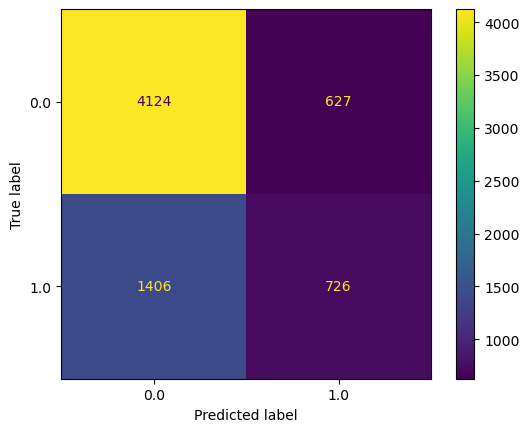

In [225]:
# plotting confusion matrix
plot_confusion_matrix(best_model, X_test, y_test);

In [226]:
# Get class predictions
y_pred = best_model.predict(X_test)

Let's get the Classification report.

In [227]:
# Classification score
dt_report = classification_report(y_test, y_pred)
print(dt_report)

              precision    recall  f1-score   support

         0.0       0.75      0.87      0.80      4751
         1.0       0.54      0.34      0.42      2132

    accuracy                           0.70      6883
   macro avg       0.64      0.60      0.61      6883
weighted avg       0.68      0.70      0.68      6883



Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                          |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|------------------------------------------------------------------------------|
| Logistic Regression | 0.696                  | 0.691             | 0.14       | 0.51          | 0.23         | MinMaxScaler(), No dimension reduction,  LR__C=1000, LR__solver='liblinear'  |
|  Decision Tree 1    | 0.722                  | 0.717             | 0.26       | 0.60          | 0.36         | max_depth=6                                                                  |
| Decision Tree 2     | 0.728                  | 0.704             | 0.34       | 0.54          | 0.42         | max_depth=7, criterion='gini'                                                |

### Random Forest

#### Optimize for `max_depth`

Let's use a for loop to optimize for max_depth. We will also use the unscaled train and validation sets for this.

In [230]:
# running model for different max depths
depths = list(range(1, int(np.sqrt(len(X_train))))) # range of max_depths to be tested
train_scores_rforest = []
validation_scores_rforest = []

for d in tqdm(depths):

    rforest = RandomForestClassifier(max_depth = d)
    rforest.fit(X_train, y_train)
        
    # Evaluate
    train_scores_rforest.append(rforest.score(X_train, y_train))
    validation_scores_rforest.append(rforest.score(X_validation, y_validation))



100%|██████████| 123/123 [05:54<00:00,  2.88s/it]


Let's plot the accuracy scores against max_depth to find out the best max_depth value.

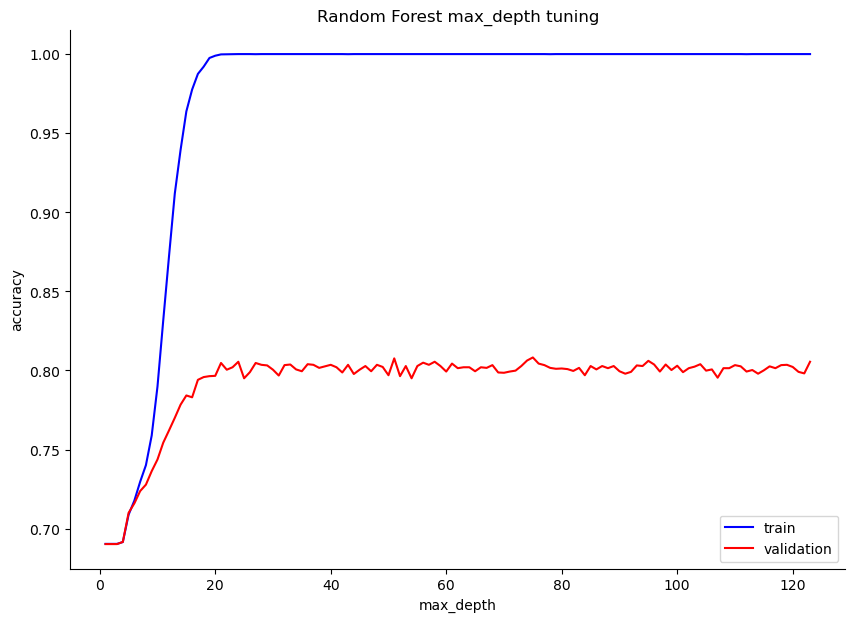

The runtime of your code is: 0:00:00.137456 (h:mm:ss)


In [231]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depths, train_scores_rforest, c='blue', label='train')
plt.plot(depths, validation_scores_rforest, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Random Forest max_depth tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

From the plot, we can see that the model starts to seriously over fit sometime around a max_depth of 20. Let's make a plot for max_depth from 1-20.

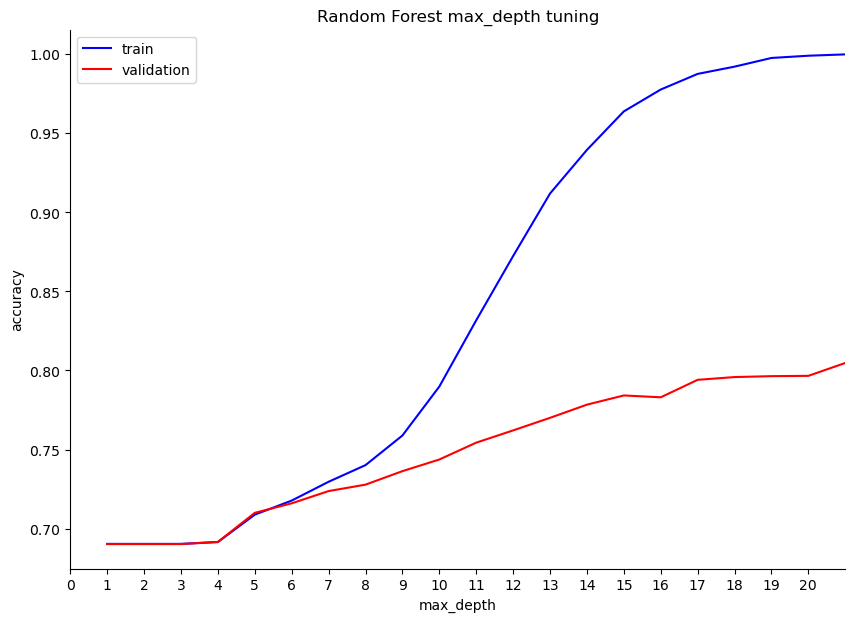

The runtime of your code is: 0:00:00.148258 (h:mm:ss)


In [233]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depths, train_scores_rforest, c='blue', label='train')
plt.plot(depths, validation_scores_rforest, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Random Forest max_depth tuning")
plt.xlim([1,21])
plt.xticks(range(0,21,1))
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Based on the plot, ideal values for `max_depth` could lie between 6 and 11. Let's run a `GridSearchCV` to see if we can find the best model.

#### 5-fold Cross Validation

We will optimize for `max_depth` and `criterion`. I will also add PCA() optimization to the mix.

In [234]:
# estimators for pipeline
estimators = [
    ('reduce_dim', PCA()),
    ('RF', RandomForestClassifier())
]

# pipeline creation
pipe = Pipeline(estimators)

Next, let's create the `param-grid`:

In [235]:
# param-grid
params = [
    {'RF': [RandomForestClassifier()],
     'reduce_dim': [PCA()],
     'RF__max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
     'RF__criterion': ['gini', 'entropy'],
     'reduce_dim__n_components': [6, 8, None]
    }
]

Now we create `GridSearchCV` object and fit the grid to the remainder data.

In [236]:
time = timer() # start timer
# GridSearchCv object
grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

# fitting the grid
fittedgrid = grid.fit(X_remainder, y_remainder)
runtime = timer(time)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   1.2s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   1.2s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   1.2s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   1.2s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   1.2s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   1.3s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=5, reduce_dim=PCA(), reduc

[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=8, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   2.5s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=8, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   2.5s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=9, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   1.9s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=9, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   2.1s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=9, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   1.9s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=9, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   2.0s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=9, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   2.1s
[CV] END RF=Ra

[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   3.3s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   3.4s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   3.5s
[CV] END RF=RandomForestClassifier(), RF__criterion=gini, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   3.3s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   1.8s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   1.8s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=5, reduce_dim=PCA(), reduce_dim__n_components=6; total time=   

[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=8, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   2.8s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=8, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   2.7s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=8, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   3.7s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=8, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   3.8s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=8, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   3.8s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=8, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   4.2s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=8, reduce_dim=PCA(), reduce_dim__n_components=None; tot

[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   3.6s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   3.6s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   3.6s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   3.7s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   3.6s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   5.1s
[CV] END RF=RandomForestClassifier(), RF__criterion=entropy, RF__max_depth=12, reduce_dim=PCA(), reduce_dim__n_components=None; total

Since the model took ~11 minutes to train, I will save fittedgrid as a .pkl file to save future computation.

In [246]:
# saving file as .pkl
joblib.dump(fittedgrid, 'randomForest_gridSearch.pkl')

['randomForest_gridSearch.pkl']

Let's find the best params and model.

In [247]:
# load .pkl file
fitgrid = joblib.load('randomForest_gridSearch.pkl')

In [248]:
# best model
best_model = fitgrid.best_estimator_

In [249]:
# Best set of parameters
fitgrid.best_params_

{'RF': RandomForestClassifier(max_depth=12),
 'RF__criterion': 'gini',
 'RF__max_depth': 12,
 'reduce_dim': PCA(),
 'reduce_dim__n_components': None}

In [250]:
# best score
fitgrid.best_score_

0.7420082250566917

#### Evaluation

##### Accuracy Scores

Let's fit the best model to the reaminder set and calculate accuracy scores.

In [240]:
time = timer()
# fit best_model
best_model.fit(X_remainder, y_remainder)
runtime = timer(time)

The runtime of your code is: 0:00:04.209640 (h:mm:ss)


In [241]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {best_model.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {best_model.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.8604707477721814
Test Set Score: 0.7444428301612669
The runtime of your code is: 0:00:00.316700 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Random Forest model and get prediction for test set.

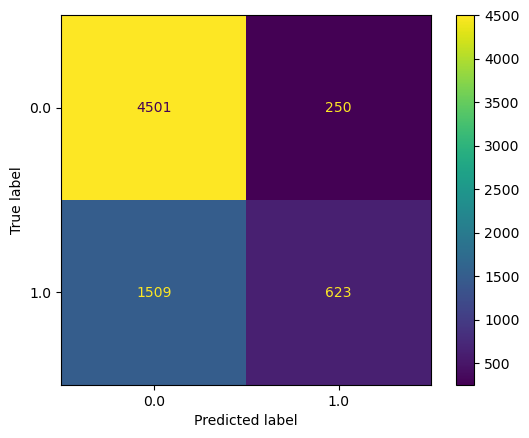

In [242]:
# plotting confusion matrix
plot_confusion_matrix(best_model, X_test, y_test);

In [243]:
# Get class predictions
y_pred = best_model.predict(X_test)

Let's get the Classification report.

In [244]:
# Classification score
rForest_report = classification_report(y_test, y_pred)
print(rForest_report)

              precision    recall  f1-score   support

         0.0       0.75      0.95      0.84      4751
         1.0       0.71      0.29      0.41      2132

    accuracy                           0.74      6883
   macro avg       0.73      0.62      0.63      6883
weighted avg       0.74      0.74      0.71      6883



Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                          |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|------------------------------------------------------------------------------|
| Logistic Regression | 0.696                  | 0.691             | 0.14       | 0.51          | 0.23         | MinMaxScaler(), No dimension reduction,  LR__C=1000, LR__solver='liblinear'  |
|  Decision Tree 1    | 0.722                  | 0.717             | 0.26       | 0.60          | 0.36         | max_depth=6                                                                  |
| Decision Tree 2     | 0.728                  | 0.704             | 0.34       | 0.54          | 0.42         | max_depth=7, criterion='gini'                                                |
| Random Forest 1     | 0.860                  | 0.744             | 0.29       | 0.71          | 0.41         | max_depth=12, criterion='gini'                                               |

`GridSearchCv` has given us quite an overfitting model. I will try a RandomForestCalssifier() with a max_depth of 10. Based on the previously plotted graph for max_depth optimization, this should lower the overfitting whil maintaining similar accuracy scores. 

In [251]:
# instantiate the model
rforest = RandomForestClassifier(max_depth=10)

# fit the model
rforest.fit(X_remainder, y_remainder)

RandomForestClassifier(max_depth=10)

##### Accuracy Scores

In [252]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {rforest.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {rforest.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.7844827586206896
Test Set Score: 0.7400842655818684
The runtime of your code is: 0:00:00.293382 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the Random Forest model and get prediction for test set.

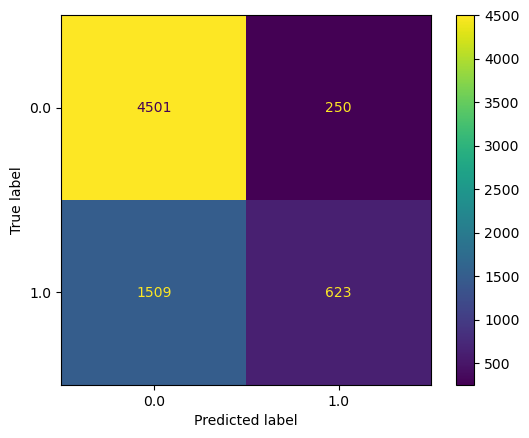

In [242]:
# plotting confusion matrix
plot_confusion_matrix(rforest, X_test, y_test);

In [243]:
# Get class predictions
y_pred = rforest.predict(X_test)

Let's get the Classification report.

In [253]:
# Classification score
rforest_report = classification_report(y_test, y_pred)
print(rforest_report)

              precision    recall  f1-score   support

         0.0       0.75      0.95      0.84      4751
         1.0       0.71      0.29      0.41      2132

    accuracy                           0.74      6883
   macro avg       0.73      0.62      0.63      6883
weighted avg       0.74      0.74      0.71      6883



Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                          |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|------------------------------------------------------------------------------|
| Logistic Regression | 0.696                  | 0.691             | 0.14       | 0.51          | 0.23         | MinMaxScaler(), No dimension reduction,  LR__C=1000, LR__solver='liblinear'  |
|  Decision Tree 1    | 0.722                  | 0.717             | 0.26       | 0.60          | 0.36         | max_depth=6                                                                  |
| Decision Tree 2     | 0.728                  | 0.704             | 0.34       | 0.54          | 0.42         | max_depth=7, criterion='gini'                                                |
| Random Forest 1     | 0.860                  | 0.744             | 0.29       | 0.71          | 0.41         | max_depth=12, criterion='gini'                                               |
| Random Forest 2     | 0.784                  | 0.740             | 0.29       | 0.71       | 0.41         | max_depth=10                                                                 |                                           |

A `max_depth` of 10 reduces the overfitting significantly while maintaining the same accuracy, recall and precision

### XGBoost Model

#### Optimize for `max_depth`

Let's use a for loop to optimize for max_depth. We will also use the unscaled train and validation sets for this.

In [256]:
# running model for different max depths
depths = list(range(1, int(np.sqrt(len(X_train))))) # range of max_depths to be tested
train_scores_xgb = []
validation_scores_xgb = []

for d in tqdm(depths):

    xgb = XGBClassifier(max_depth = d)
    xgb.fit(X_train, y_train)
        
    # Evaluate
    train_scores_xgb.append(xgb.score(X_train, y_train))
    validation_scores_xgb.append(xgb.score(X_validation, y_validation))



  1%|          | 1/123 [00:00<00:23,  5.09it/s]

[02:04:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:04:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  2%|▏         | 2/123 [00:00<00:30,  3.99it/s]

[02:04:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  2%|▏         | 3/123 [00:00<00:37,  3.17it/s]

[02:04:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  3%|▎         | 4/123 [00:01<00:53,  2.22it/s]

[02:04:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  4%|▍         | 5/123 [00:02<01:07,  1.74it/s]

[02:04:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  5%|▍         | 6/123 [00:03<01:16,  1.52it/s]

[02:04:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  6%|▌         | 7/123 [00:04<01:30,  1.28it/s]

[02:04:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  7%|▋         | 8/123 [00:05<01:45,  1.10it/s]

[02:04:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  7%|▋         | 9/123 [00:06<02:02,  1.07s/it]

[02:04:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  8%|▊         | 10/123 [00:08<02:19,  1.24s/it]

[02:04:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  9%|▉         | 11/123 [00:10<02:40,  1.43s/it]

[02:04:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 10%|▉         | 12/123 [00:12<03:01,  1.63s/it]

[02:04:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 11%|█         | 13/123 [00:14<03:17,  1.79s/it]

[02:04:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 11%|█▏        | 14/123 [00:16<03:32,  1.95s/it]

[02:04:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 12%|█▏        | 15/123 [00:19<04:02,  2.24s/it]

[02:04:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 13%|█▎        | 16/123 [00:22<04:14,  2.38s/it]

[02:04:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 14%|█▍        | 17/123 [00:25<04:21,  2.47s/it]

[02:04:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 15%|█▍        | 18/123 [00:27<04:28,  2.56s/it]

[02:04:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 15%|█▌        | 19/123 [00:30<04:32,  2.62s/it]

[02:04:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 16%|█▋        | 20/123 [00:33<04:45,  2.77s/it]

[02:04:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 17%|█▋        | 21/123 [00:36<04:55,  2.90s/it]

[02:04:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 18%|█▊        | 22/123 [00:40<05:00,  2.97s/it]

[02:04:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 19%|█▊        | 23/123 [00:43<05:05,  3.06s/it]

[02:04:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|█▉        | 24/123 [00:46<05:10,  3.14s/it]

[02:04:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|██        | 25/123 [00:50<05:17,  3.24s/it]

[02:05:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 21%|██        | 26/123 [00:53<05:16,  3.26s/it]

[02:05:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 22%|██▏       | 27/123 [00:56<05:19,  3.33s/it]

[02:05:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 23%|██▎       | 28/123 [01:00<05:16,  3.33s/it]

[02:05:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 24%|██▎       | 29/123 [01:03<05:18,  3.39s/it]

[02:05:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 24%|██▍       | 30/123 [01:07<05:35,  3.61s/it]

[02:05:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 25%|██▌       | 31/123 [01:11<05:27,  3.56s/it]

[02:05:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 26%|██▌       | 32/123 [01:14<05:16,  3.48s/it]

[02:05:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 27%|██▋       | 33/123 [01:18<05:08,  3.43s/it]

[02:05:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 28%|██▊       | 34/123 [01:21<05:07,  3.46s/it]

[02:05:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 28%|██▊       | 35/123 [01:25<05:06,  3.49s/it]

[02:05:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 29%|██▉       | 36/123 [01:28<04:59,  3.45s/it]

[02:05:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 30%|███       | 37/123 [01:31<04:56,  3.45s/it]

[02:05:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 31%|███       | 38/123 [01:35<04:51,  3.43s/it]

[02:05:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 32%|███▏      | 39/123 [01:39<04:57,  3.54s/it]

[02:05:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 33%|███▎      | 40/123 [01:42<04:49,  3.49s/it]

[02:05:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 33%|███▎      | 41/123 [01:46<04:52,  3.56s/it]

[02:05:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 34%|███▍      | 42/123 [01:49<04:44,  3.51s/it]

[02:06:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 35%|███▍      | 43/123 [01:52<04:33,  3.41s/it]

[02:06:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 36%|███▌      | 44/123 [01:56<04:32,  3.45s/it]

[02:06:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 37%|███▋      | 45/123 [01:59<04:26,  3.41s/it]

[02:06:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 37%|███▋      | 46/123 [02:02<04:20,  3.38s/it]

[02:06:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 38%|███▊      | 47/123 [02:06<04:17,  3.38s/it]

[02:06:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 39%|███▉      | 48/123 [02:09<04:17,  3.43s/it]

[02:06:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|███▉      | 49/123 [02:13<04:14,  3.44s/it]

[02:06:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 41%|████      | 50/123 [02:16<04:11,  3.45s/it]

[02:06:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 41%|████▏     | 51/123 [02:20<04:11,  3.49s/it]

[02:06:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 42%|████▏     | 52/123 [02:24<04:11,  3.54s/it]

[02:06:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 43%|████▎     | 53/123 [02:28<04:19,  3.70s/it]

[02:06:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 44%|████▍     | 54/123 [02:31<04:15,  3.70s/it]

[02:06:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 45%|████▍     | 55/123 [02:35<04:12,  3.71s/it]

[02:06:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 46%|████▌     | 56/123 [02:39<04:08,  3.71s/it]

[02:06:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 46%|████▋     | 57/123 [02:43<04:09,  3.78s/it]

[02:06:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 47%|████▋     | 58/123 [02:46<04:02,  3.73s/it]

[02:06:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 48%|████▊     | 59/123 [02:50<03:57,  3.71s/it]

[02:07:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 49%|████▉     | 60/123 [02:54<03:51,  3.67s/it]

[02:07:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|████▉     | 61/123 [02:57<03:49,  3.69s/it]

[02:07:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|█████     | 62/123 [03:01<03:46,  3.71s/it]

[02:07:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 51%|█████     | 63/123 [03:05<03:40,  3.68s/it]

[02:07:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 52%|█████▏    | 64/123 [03:08<03:36,  3.67s/it]

[02:07:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 53%|█████▎    | 65/123 [03:12<03:32,  3.67s/it]

[02:07:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 54%|█████▎    | 66/123 [03:16<03:34,  3.76s/it]

[02:07:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 54%|█████▍    | 67/123 [03:20<03:27,  3.71s/it]

[02:07:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 55%|█████▌    | 68/123 [03:23<03:20,  3.65s/it]

[02:07:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 56%|█████▌    | 69/123 [03:27<03:16,  3.64s/it]

[02:07:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 57%|█████▋    | 70/123 [03:31<03:17,  3.73s/it]

[02:07:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 58%|█████▊    | 71/123 [03:34<03:11,  3.68s/it]

[02:07:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 59%|█████▊    | 72/123 [03:38<03:11,  3.75s/it]

[02:07:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 59%|█████▉    | 73/123 [03:42<03:07,  3.75s/it]

[02:07:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|██████    | 74/123 [03:46<03:04,  3.77s/it]

[02:07:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 61%|██████    | 75/123 [03:49<02:59,  3.74s/it]

[02:08:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 62%|██████▏   | 76/123 [03:53<02:54,  3.71s/it]

[02:08:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 63%|██████▎   | 77/123 [03:57<02:49,  3.69s/it]

[02:08:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 63%|██████▎   | 78/123 [04:01<02:51,  3.82s/it]

[02:08:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 64%|██████▍   | 79/123 [04:05<02:57,  4.03s/it]

[02:08:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 65%|██████▌   | 80/123 [04:09<02:52,  4.00s/it]

[02:08:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 66%|██████▌   | 81/123 [04:13<02:49,  4.03s/it]

[02:08:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 67%|██████▋   | 82/123 [04:17<02:45,  4.05s/it]

[02:08:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 67%|██████▋   | 83/123 [04:21<02:39,  3.98s/it]

[02:08:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 68%|██████▊   | 84/123 [04:25<02:37,  4.03s/it]

[02:08:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 69%|██████▉   | 85/123 [04:29<02:27,  3.88s/it]

[02:08:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 70%|██████▉   | 86/123 [04:32<02:19,  3.77s/it]

[02:08:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 71%|███████   | 87/123 [04:36<02:17,  3.82s/it]

[02:08:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 88/123 [04:40<02:12,  3.78s/it]

[02:08:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 89/123 [04:44<02:06,  3.72s/it]

[02:08:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 73%|███████▎  | 90/123 [04:47<02:01,  3.67s/it]

[02:08:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 74%|███████▍  | 91/123 [04:51<02:00,  3.76s/it]

[02:09:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 75%|███████▍  | 92/123 [04:55<01:55,  3.74s/it]

[02:09:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▌  | 93/123 [04:58<01:50,  3.69s/it]

[02:09:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 76%|███████▋  | 94/123 [05:02<01:46,  3.66s/it]

[02:09:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 77%|███████▋  | 95/123 [05:06<01:44,  3.72s/it]

[02:09:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 78%|███████▊  | 96/123 [05:09<01:39,  3.68s/it]

[02:09:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 79%|███████▉  | 97/123 [05:13<01:34,  3.64s/it]

[02:09:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|███████▉  | 98/123 [05:17<01:30,  3.62s/it]

[02:09:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 99/123 [05:20<01:26,  3.61s/it]

[02:09:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 81%|████████▏ | 100/123 [05:24<01:25,  3.72s/it]

[02:09:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 82%|████████▏ | 101/123 [05:28<01:21,  3.68s/it]

[02:09:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 102/123 [05:31<01:16,  3.66s/it]

[02:09:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 84%|████████▎ | 103/123 [05:35<01:14,  3.73s/it]

[02:09:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 85%|████████▍ | 104/123 [05:40<01:14,  3.89s/it]

[02:09:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 85%|████████▌ | 105/123 [05:43<01:10,  3.90s/it]

[02:09:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 86%|████████▌ | 106/123 [05:47<01:05,  3.83s/it]

[02:09:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 87%|████████▋ | 107/123 [05:51<01:00,  3.76s/it]

[02:10:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 88%|████████▊ | 108/123 [05:55<00:57,  3.81s/it]

[02:10:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 89%|████████▊ | 109/123 [05:58<00:52,  3.74s/it]

[02:10:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 89%|████████▉ | 110/123 [06:02<00:48,  3.74s/it]

[02:10:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|█████████ | 111/123 [06:06<00:44,  3.70s/it]

[02:10:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 91%|█████████ | 112/123 [06:09<00:40,  3.71s/it]

[02:10:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 92%|█████████▏| 113/123 [06:13<00:37,  3.72s/it]

[02:10:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 114/123 [06:17<00:33,  3.68s/it]

[02:10:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 115/123 [06:20<00:29,  3.65s/it]

[02:10:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 94%|█████████▍| 116/123 [06:24<00:25,  3.66s/it]

[02:10:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 95%|█████████▌| 117/123 [06:28<00:22,  3.74s/it]

[02:10:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 96%|█████████▌| 118/123 [06:31<00:18,  3.69s/it]

[02:10:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 119/123 [06:35<00:14,  3.66s/it]

[02:10:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 98%|█████████▊| 120/123 [06:39<00:10,  3.65s/it]

[02:10:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 98%|█████████▊| 121/123 [06:43<00:07,  3.78s/it]

[02:10:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 99%|█████████▉| 122/123 [06:46<00:03,  3.76s/it]

[02:10:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 123/123 [06:50<00:00,  3.34s/it]


Let's plot the accuracy scores against max_depth to find out the best max_depth value.

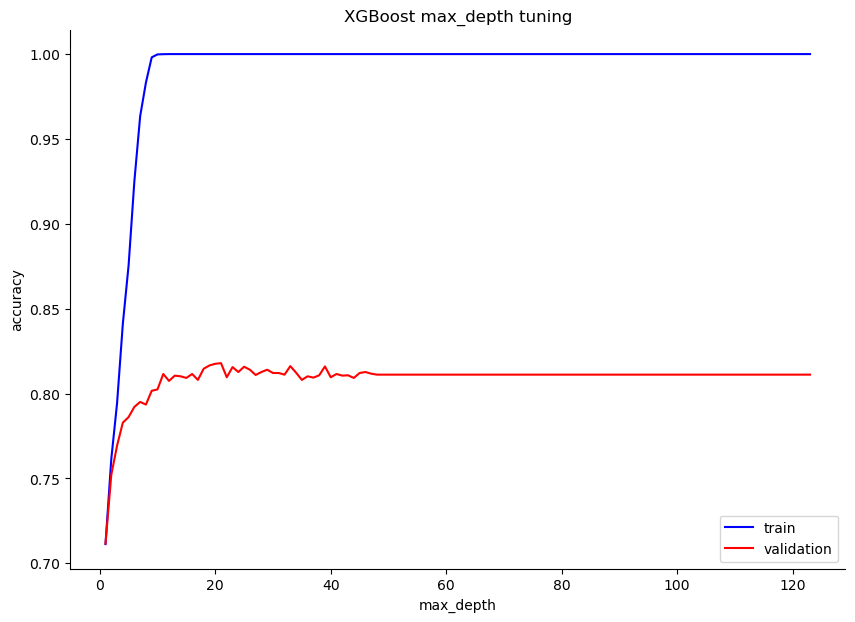

The runtime of your code is: 0:00:00.140269 (h:mm:ss)


In [257]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depths, train_scores_xgb, c='blue', label='train')
plt.plot(depths, validation_scores_xgb, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("XGBoost max_depth tuning")
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

From the plot, we can see that the model starts to seriously over fit sometime around a max_depth of 20. Let's make a plot for max_depth from 1-20.

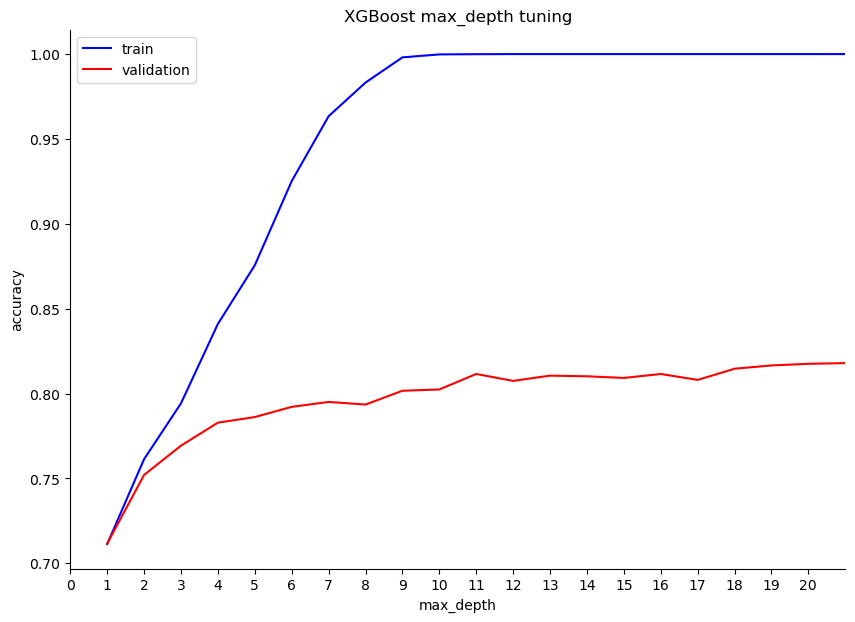

The runtime of your code is: 0:00:00.148420 (h:mm:ss)


In [258]:
time = timer()
plt.figure(figsize=(10, 7))
plt.plot(depths, train_scores_xgb, c='blue', label='train')
plt.plot(depths, validation_scores_xgb, c='red', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("XGBoost max_depth tuning")
plt.xlim([1,21])
plt.xticks(range(0,21,1))
plt.legend()

sns.despine()
plt.show()
runtime = timer(time)

Based on the plot, ideal values for `max_depth` could lie between 4 and 6. Let's run a `GridSearchCV` to see if we can find the best model.

#### 5-fold Cross Validation

I will run a `GridSearchCV` to optimize for `max_depth`, `'n_estimators` and `learning_rate`. I will also add some dimension redcution with PCA().

In [260]:
# specify the components
estimators = [
    ('reduce_dim', PCA()), 
    ('model', XGBClassifier())
]

# create pipeline
my_pipe = Pipeline(estimators)


# grid for searching
param_grid = [
    {
        'model': [XGBClassifier()],
        'reduce_dim': [PCA()],
        'model__max_depth': [4, 5, 6],
        'model__n_estimators': range(10, 201, 40),
        'model__learning_rate': [0.5, 1, 2],
        'reduce_dim__n_components': [8, None]
    }
]

time = timer() # start timer
grid = GridSearchCV(my_pipe, param_grid, cv=5, verbose=2)

fittedgrid = grid.fit(X_train, y_train)
runtime = timer(time)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[02:16:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, 

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=10, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.0s
[02:16:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default ev

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.2s
[02:16:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default ev

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.4s
[02:16:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalu

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.5s
[02:16:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.8s
[02:16:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default e

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   1.1s
[02:16:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default e

[02:16:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_param

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.3s
[02:16:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalu

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.5s
[02:16:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalu

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.7s
[02:16:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default ev

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   1.0s
[02:17:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default e

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   1.4s
[02:17:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default e

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=10, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.0s
[02:17:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalu

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.3s
[02:17:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalu

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.4s
[02:17:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default ev

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.9s
[02:17:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default ev

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   1.3s
[02:17:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default e

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   1.1s
[02:17:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[02:18:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_param

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=4, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.2s
[02:18:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluat

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=4, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.4s
[02:18:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=4, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.6s
[02:18:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=4, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.6s
[02:18:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=4, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.8s
[02:18:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=5, model__n_estimators=10, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.0s
[02:18:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluat

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=5, model__n_estimators=10, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.1s
[02:18:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=5, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.4s
[02:18:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=5, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.8s
[02:18:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=5, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.8s
[02:18:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=5, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   1.1s
[02:18:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=5, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   1.6s
[02:19:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eva

[02:19:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_param

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=6, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.6s
[02:19:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=6, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.7s
[02:19:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluat

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=6, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   1.0s
[02:19:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=6, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   1.6s
[02:19:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eva

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=6, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   2.0s
[02:19:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eva

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=4, model__n_estimators=10, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.0s
[02:20:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[02:20:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_param

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=4, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.2s
[02:20:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluat

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=4, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.4s
[02:20:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=4, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.2s
[02:20:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eva

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=4, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.3s
[02:20:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=5, model__n_estimators=10, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.0s
[02:20:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluat

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=5, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.2s
[02:20:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluat

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=5, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.2s
[02:20:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=5, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.2s
[02:20:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=5, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.8s
[02:20:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eva

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=5, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.3s
[02:20:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=6, model__n_estimators=10, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.0s
[02:20:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluat

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=6, model__n_estimators=10, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.1s
[02:20:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=6, model__n_estimators=50, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.5s
[02:20:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=6, model__n_estimators=90, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.7s
[02:20:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=6, model__n_estimators=130, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.4s
[02:20:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=6, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=8; total time=   0.9s
[02:20:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evalua

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=2, model__max_depth=6, model__n_estimators=170, reduce_dim=PCA(), reduce_dim__n_components=None; total time=   0.5s
[02:21:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default eva

I will save the fittedgrid to a .pkl file.

In [261]:
# saving to .pkl
joblib.dump(fittedgrid, 'XGBoost_gridsearch.pkl')

['XGBoost_gridsearch.pkl']

In [262]:
xgb_fitgrid = joblib.load('XGBoost_gridsearch.pkl')

In [264]:
# best model
best_model = xgb_fitgrid.best_estimator_

In [265]:
# Best set of parameters
xgb_fitgrid.best_params_

{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.5, max_delta_step=None, max_depth=6,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=170, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, reg_alpha=None,
               reg_lambda=None, scale_pos_weight=None, subsample=None,
               tree_method=None, validate_parameters=None, verbosity=None),
 'model__learning_rate': 0.5,
 'model__max_depth': 6,
 'model__n_estimators': 170,
 'reduce_dim': PCA(),
 'reduce_dim__n_components': None}

In [266]:
# best score
xgb_fitgrid.best_score_

0.736988668306633

#### Evaluation

##### Accuracy Scores

Let's fit the best model to the remainder set and calculate accuracy scores.

In [267]:
time = timer()
# fit best_model
best_model.fit(X_remainder, y_remainder)
runtime = timer(time)

[02:26:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The runtime of your code is: 0:00:02.546703 (h:mm:ss)


In [268]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {best_model.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {best_model.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.986536226268888
Test Set Score: 0.7492372511986053
The runtime of your code is: 0:00:00.055504 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the XGBoost model and get prediction for test set.

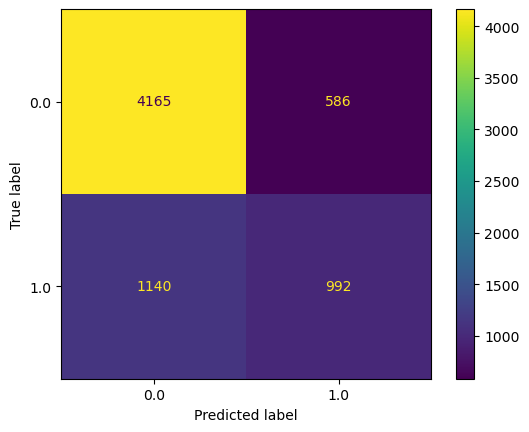

In [269]:
# plotting confusion matrix
plot_confusion_matrix(best_model, X_test, y_test);

In [270]:
# Get class predictions
y_pred = best_model.predict(X_test)

Let's get the Classification report.

In [272]:
# Classification score
xgb_report = classification_report(y_test, y_pred)
print(xgb_report)

              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83      4751
         1.0       0.63      0.47      0.53      2132

    accuracy                           0.75      6883
   macro avg       0.71      0.67      0.68      6883
weighted avg       0.74      0.75      0.74      6883



Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                          |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|------------------------------------------------------------------------------|
| Logistic Regression | 0.696                  | 0.691             | 0.14       | 0.51          | 0.23         | MinMaxScaler(), No dimension reduction,  LR__C=1000, LR__solver='liblinear'  |
|  Decision Tree 1    | 0.722                  | 0.717             | 0.26       | 0.60          | 0.36         | max_depth=6                                                                  |
| Decision Tree 2     | 0.728                  | 0.704             | 0.34       | 0.54          | 0.42         | max_depth=7, criterion='gini'                                                |
| Random Forest 1     | 0.860                  | 0.744             | 0.29       | 0.71          | 0.41         | max_depth=12, criterion='gini'                                               |
| Random Forest 2     | 0.784                  | 0.740             | 0.29       | 0.71          | 0.41         | max_depth=10                                                                 |
| XGBoost 1           | 0.986                  | 0.749             | 0.47       | 0.63          | 0.53         | learning_rate=0.5, max_depth=6, n_estimators=170                             |

This model gives us a much better F1 score (0.53), providing the best recall yet (0.47). The test accuracy score is also quite strong with (0.749). However, it is incredibly overfitting. I will train a model with `max_depth` of 4 to try and reduce overfitting. 

In [273]:
# instantiate the model
xgb = XGBClassifier(max_depth=4, n_components=170, learning_rate=0.5)

# fit the model
xgb.fit(X_remainder, y_remainder)

[02:33:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "n_components" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:33:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_components=170, n_estimators=100,
              n_jobs=6, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

##### Accuracy Scores

In [274]:
time = timer()
# accuracy scores
print(f'Remainder Set Score: {xgb.score(X_remainder, y_remainder)}')
print(f'Test Set Score: {xgb.score(X_test, y_test)}')
runtime = timer(time)

Remainder Set Score: 0.8526249515691593
Test Set Score: 0.7793113467964551
The runtime of your code is: 0:00:00.023003 (h:mm:ss)


##### Precision and Recall

Let's plot the confusion matrix for the XGBoost model and get prediction for test set.

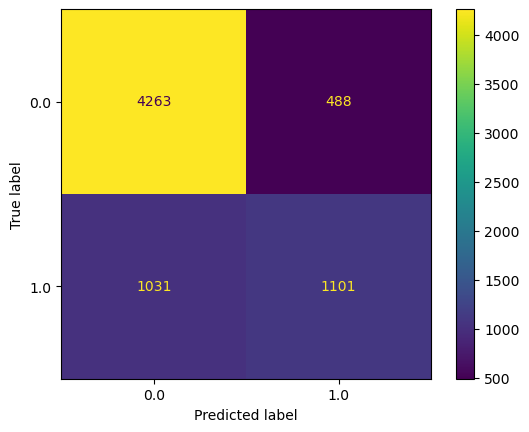

In [275]:
# plotting confusion matrix
plot_confusion_matrix(xgb, X_test, y_test);

In [276]:
# Get class predictions
y_pred = xgb.predict(X_test)

Let's get the Classification report.

In [277]:
# Classification score
xgb_report = classification_report(y_test, y_pred)
print(xgb_report)

              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85      4751
         1.0       0.69      0.52      0.59      2132

    accuracy                           0.78      6883
   macro avg       0.75      0.71      0.72      6883
weighted avg       0.77      0.78      0.77      6883



Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                          |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|------------------------------------------------------------------------------|
| Logistic Regression | 0.696                  | 0.691             | 0.14       | 0.51          | 0.23         | MinMaxScaler(), No dimension reduction,  LR__C=1000, LR__solver='liblinear'  |
|  Decision Tree 1    | 0.722                  | 0.717             | 0.26       | 0.60          | 0.36         | max_depth=6                                                                  |
| Decision Tree 2     | 0.728                  | 0.704             | 0.34       | 0.54          | 0.42         | max_depth=7, criterion='gini'                                                |
| Random Forest 1     | 0.860                  | 0.744             | 0.29       | 0.71          | 0.41         | max_depth=12, criterion='gini'                                               |
| Random Forest 2     | 0.784                  | 0.740             | 0.29       | 0.71          | 0.41         | max_depth=10                                                                 |
| XGBoost 1           | 0.986                  | 0.749             | 0.47       | 0.63          | 0.53         | learning_rate=0.5, max_depth=6, n_estimators=170                             |
| XGBoost 2           | 0.852                  | 0.779             | 0.69       | 0.52          | 0.59         | learning_rate=0.5, max_depth=4, n_estimators=170                             |

A `max_depth` of 4 reduces the overfitting significantly while giving a significant increase in test accuracy score (0.779), recall (0.69) and F1 score (0.59). The precision does go down to 0.52 however. 

This model is significantly better than the other models we have had so far. 

**XGBoost shows great promise**.

-----------------------

## Summary

Below is the summary table for modeling and evaluation of models.

Summary of Models:

|      **Model**      | **Remainder Accuracy** | **Test Accuracy** | **Recall** | **Precision** | **F1 Score** | **Best Parameters**                                                          |
|:-------------------:|:----------------------:|:-----------------:|------------|---------------|--------------|------------------------------------------------------------------------------|
| Logistic Regression | 0.696                  | 0.691             | 0.14       | 0.51          | 0.23         | MinMaxScaler(), No dimension reduction,  LR__C=1000, LR__solver='liblinear'  |
|  Decision Tree 1    | 0.722                  | 0.717             | 0.26       | 0.60          | 0.36         | max_depth=6                                                                  |
| Decision Tree 2     | 0.728                  | 0.704             | 0.34       | 0.54          | 0.42         | max_depth=7, criterion='gini'                                                |
| Random Forest 1     | 0.860                  | 0.744             | 0.29       | 0.71          | 0.41         | max_depth=12, criterion='gini'                                               |
| Random Forest 2     | 0.784                  | 0.740             | 0.29       | 0.71          | 0.41         | max_depth=10                                                                 |
| XGBoost 1           | 0.986                  | 0.749             | 0.47       | 0.63          | 0.53         | learning_rate=0.5, max_depth=6, n_estimators=170                             |
| XGBoost 2           | 0.852                  | 0.779             | 0.69       | 0.52          | 0.59         | learning_rate=0.5, max_depth=4, n_estimators=170                             |

The XGBoost model with `leanring_rate=0.5`, `max_depth=4` and `n_estimators=170` is by far the best model we have found. It gives us a test accuracy score of ~0.78, a Recall of 0.69, a Precision of 0.52 and a F1 Score of 0.59. 

I think these values can be further increased by:
- Adding more weather features to the dataset
- Tuning the hyperparameters in more detail

**Note: The Random Forest models give us the best Precision i.e. the least False positives. This would help minimize loss unneeded economic loss by not making people who don't need to evacuate, evacuate.**

--------------------------